# Временные ряды

**Этот материал исключительно обзорный и, на текущий момент, существенно неполный. При интересе к теме лучше почитать вот [этот блогпост](https://habr.com/ru/company/ods/blog/327242/), например**


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

> Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки

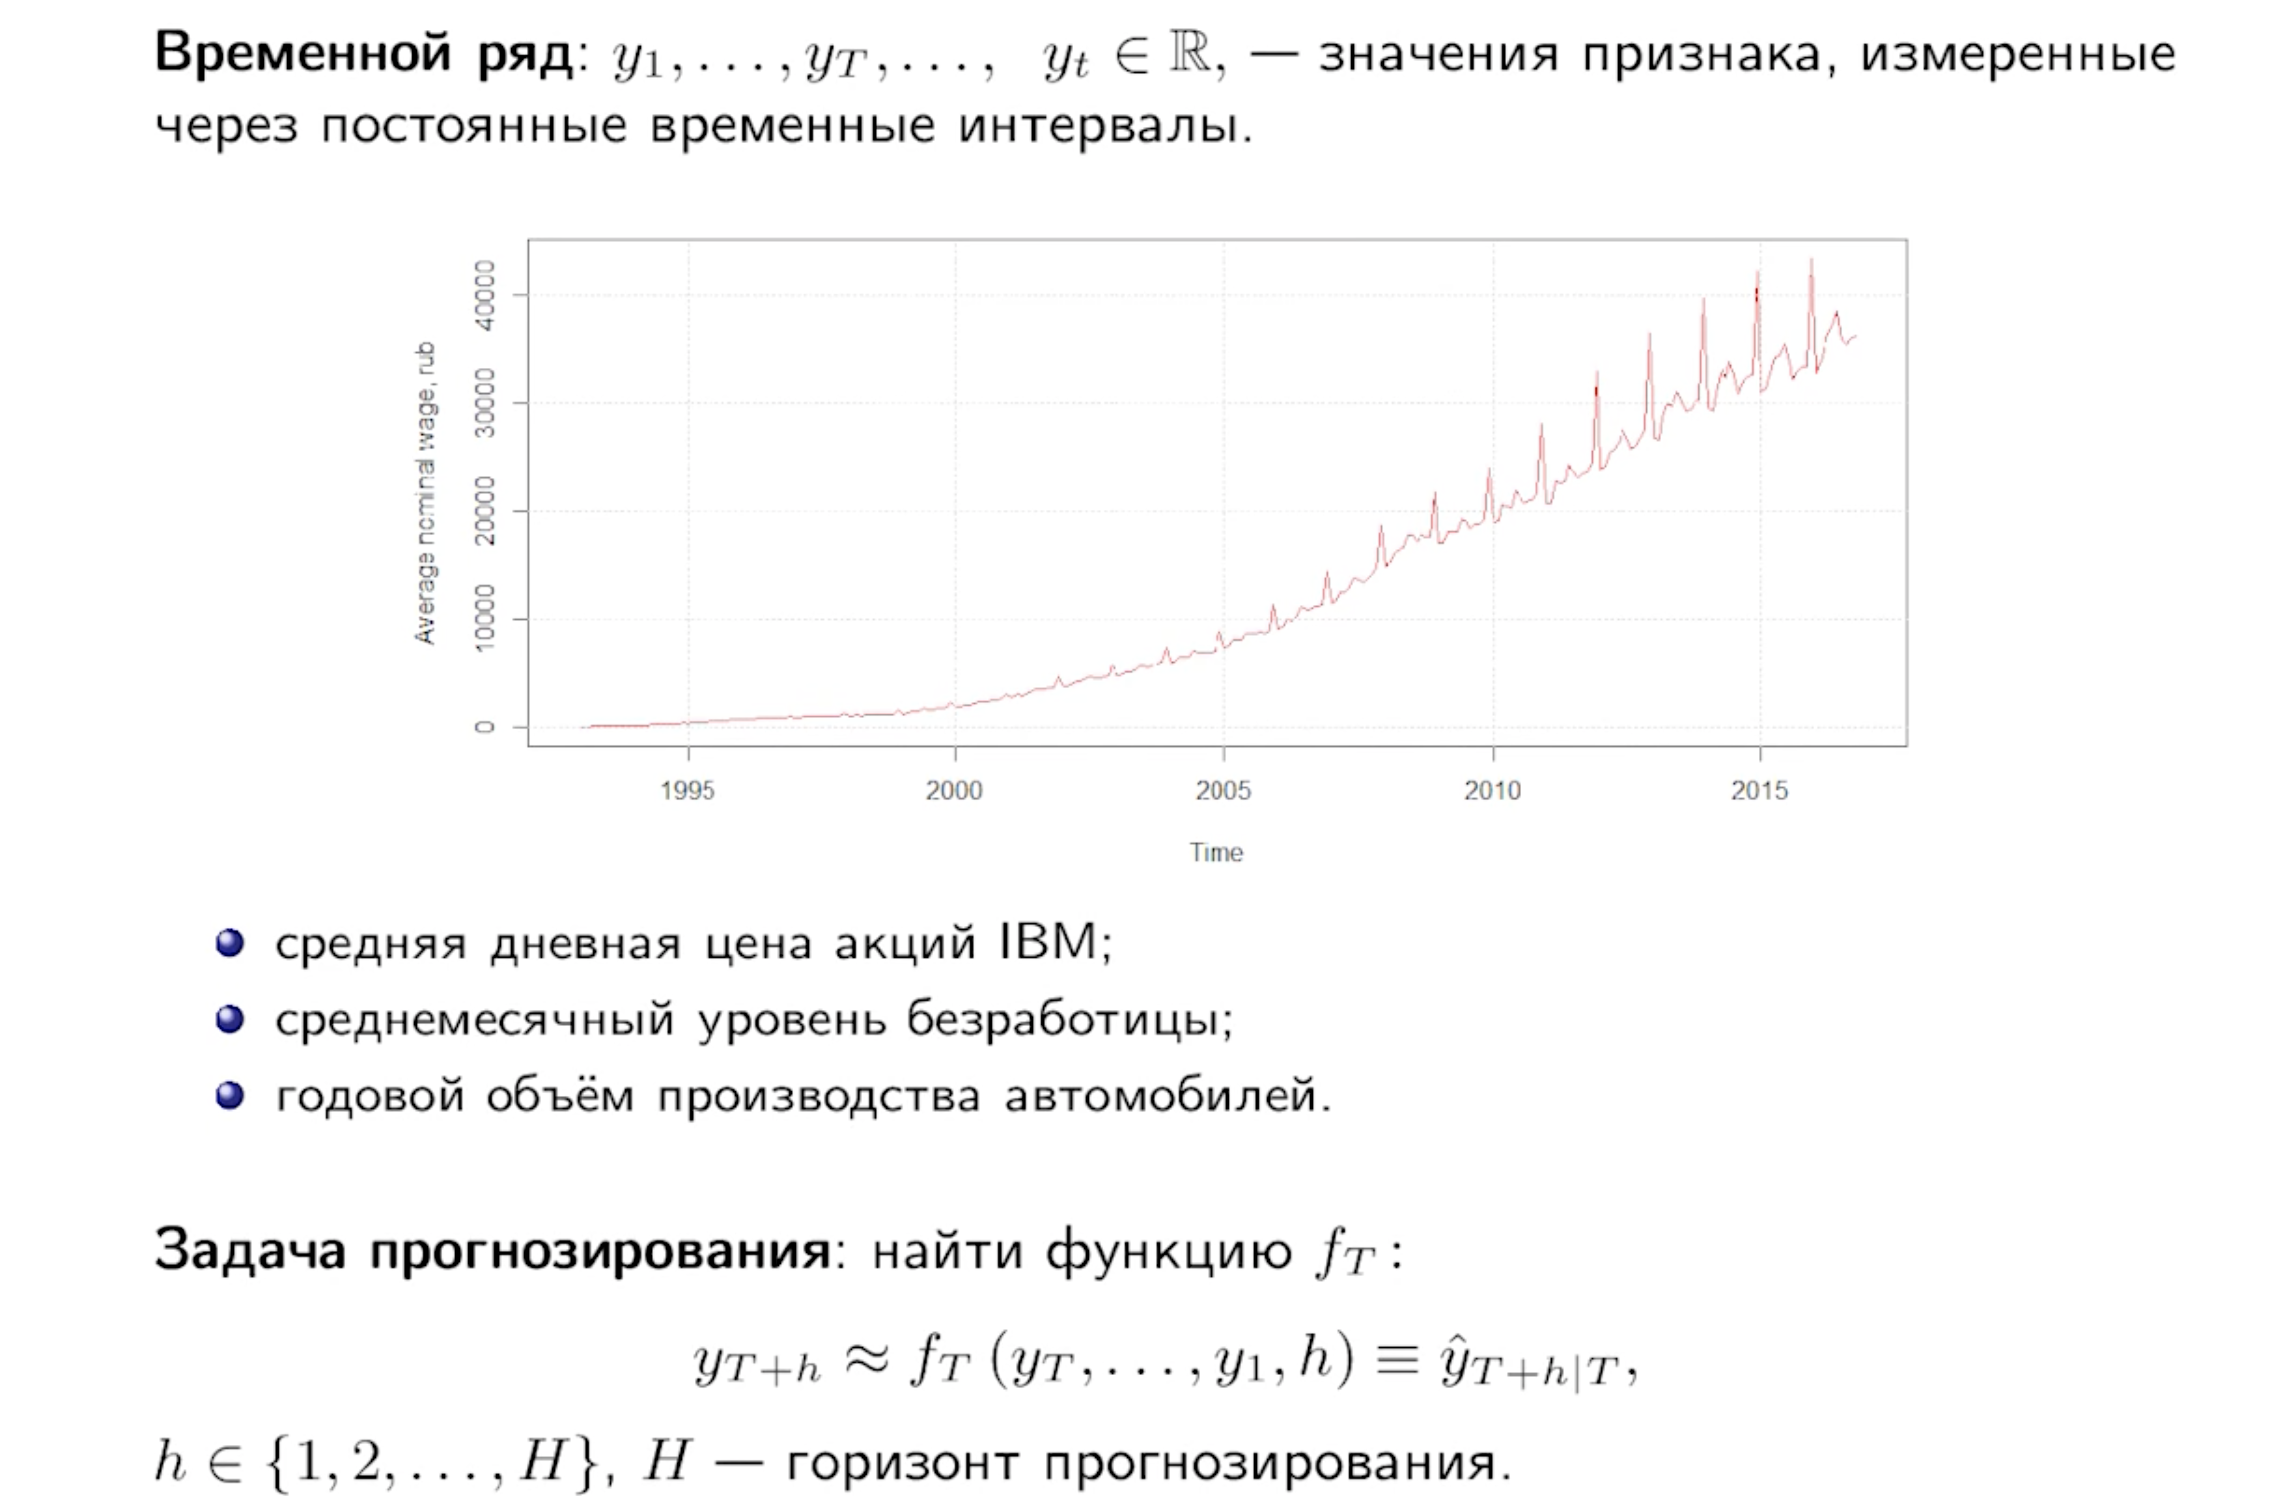

In [21]:
Image('images/tsintro.png', width=1000)

In [22]:
data = pd.read_csv('data/tsla.us.txt').drop(columns=['OpenInt'])
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-28,17.00,17.00,17.00,17.00,0
2010-06-29,19.00,25.00,17.54,23.89,18783276
2010-06-30,25.79,30.42,23.30,23.83,17194394
2010-07-01,25.00,25.92,20.27,21.96,8229863
2010-07-02,23.00,23.10,18.71,19.20,5141807


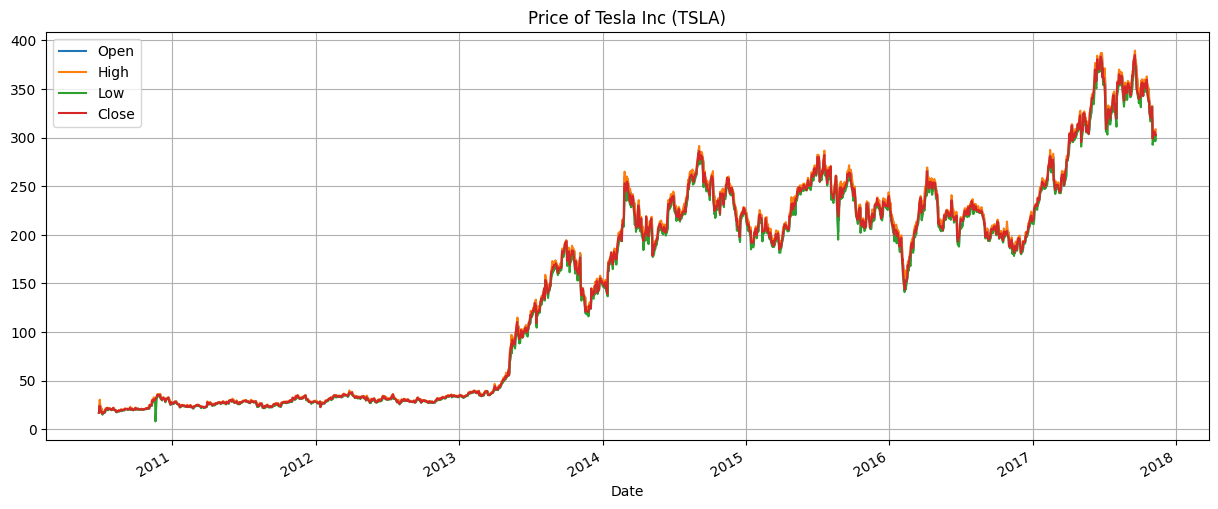

In [23]:
data[['Open', 'High', 'Low', 'Close']].plot(figsize=(15, 6), 
                                            title='Price of Tesla Inc (TSLA)')
plt.grid()

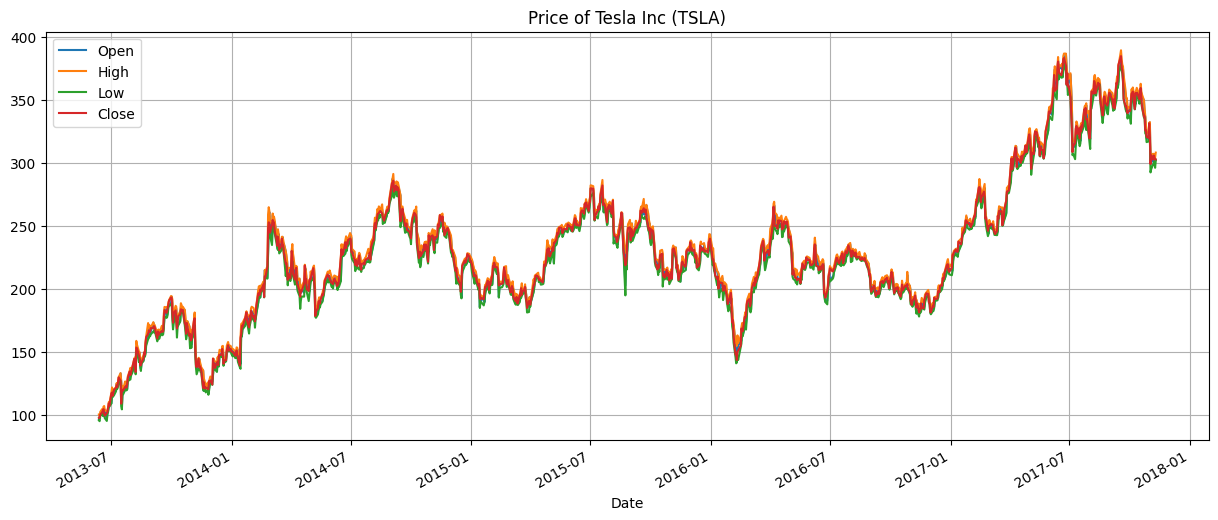

In [24]:
data = data.iloc[int(len(data)*0.4):]
data[['Open', 'High', 'Low', 'Close']].plot(figsize=(15, 6), 
                                            title='Price of Tesla Inc (TSLA)')
plt.grid()

## Daily return
Сколько заработаем, если вчера вечером купили, а сегодня вечером продадим.

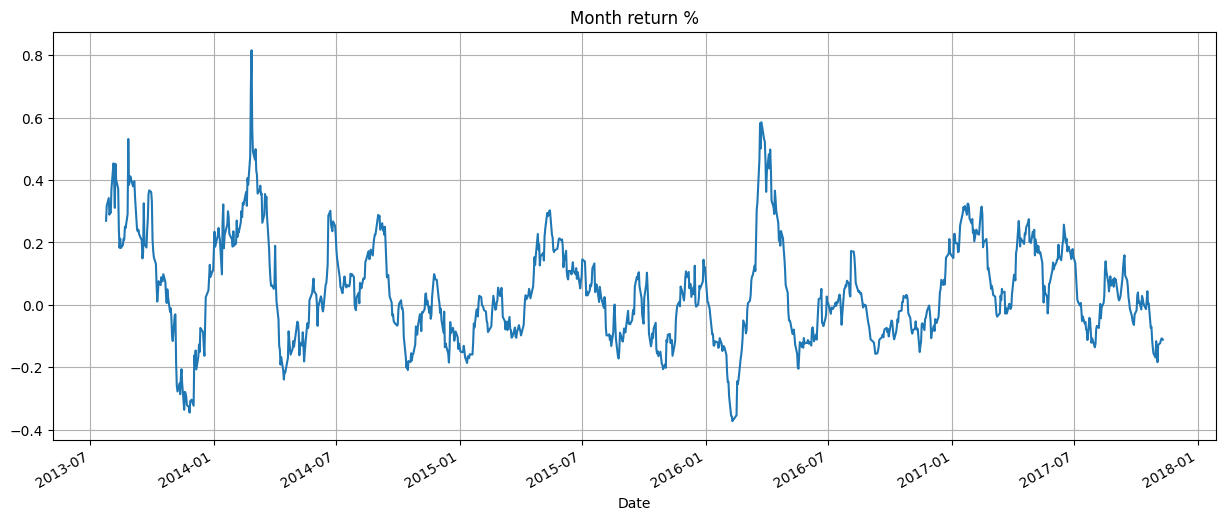

In [25]:
data['Daily return'] = data['Close'].pct_change(periods=30)
data['Daily return'].plot(figsize=((15,6)), title='Month return %')
plt.grid()

<Figure size 700x500 with 0 Axes>

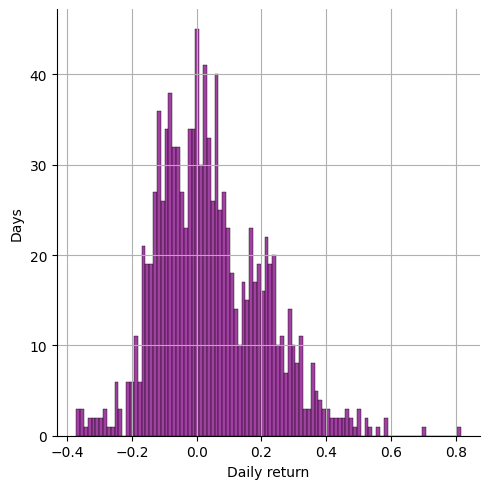

In [26]:
plt.figure(figsize=(7,5))
sns.displot(data['Daily return'].dropna(), bins=100, color='purple')
plt.ylabel('Days')
plt.grid()

## Постановка задачи

Пусть данные $y$ - некоторое значение параметра. 

Необходимо делать предсказание $y$ на будущее.

Основные отличия:

* Объекты **ЗАВИСИМЫ** в отличие от регресии/классификации/кластеризации.

* Возможно есть какие-то доп. признаки для каждой даты, но иногда только дата.

Пока будем предсказывать $y_{t+1}$, потом посмотрим, что будем с горизонтом.

In [27]:
data['Close+1'] = data['Close'].shift(1)
data['Close+5'] = data['Close'].shift(5)
data['Close+10'] = data['Close'].shift(10)

data = data[:-10]

In [28]:
data[['Close', 'Close+1', 'Close+5', 'Close+10']].tail(12)

,Close,Close+1,Close+5,Close+10
Date,,,,
2017-10-12,355.68,354.60,355.140,339.600
2017-10-13,355.57,355.68,356.834,341.020
2017-10-16,350.60,355.57,342.940,341.530
2017-10-17,355.75,350.60,355.590,348.140
2017-10-18,359.65,355.75,354.600,355.010
2017-10-19,351.81,359.65,355.680,355.140
2017-10-20,345.10,351.81,355.570,356.834
2017-10-23,337.02,345.10,350.600,342.940
2017-10-24,337.34,337.02,355.750,355.590


In [29]:
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

def result(data, sol_cols, targets=['Close+1', 'Close+10'], test_size=0.1):
    
    test_size = 0.1
    test_data = data[-int(len(data)*test_size):]
    for target in targets:
        title_ = target + ': '
        for sol in sol_cols:
            error = MSE(test_data[sol], test_data[target])
            title_ += '{0} MSE: {1:.2f}, '.format(sol, error)
        test_data[[target, *sol_cols]].plot(figsize=(15, 6), 
                                            title=title_, lw=3, alpha=.8)
        plt.grid()

## Решения

### 1. Очень тупое

$$y_{t+h} = y_{t}$$

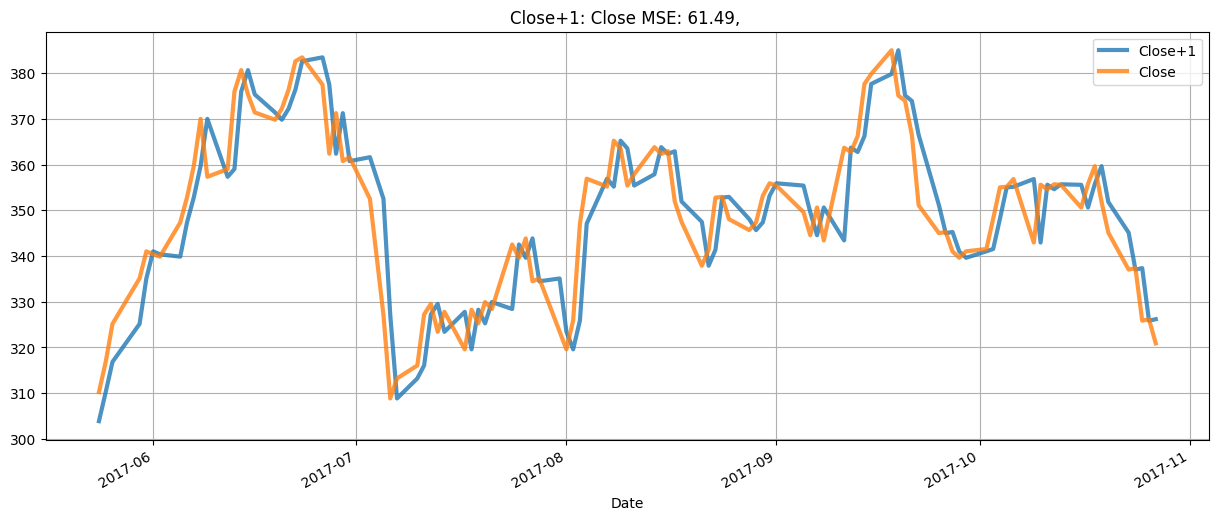

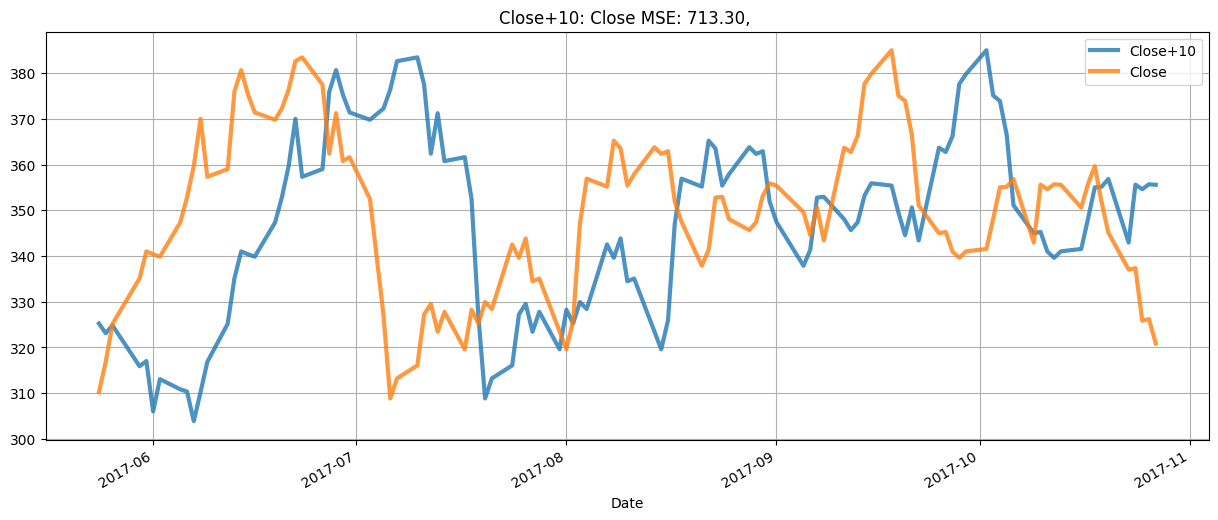

In [30]:
result(data,sol_cols = ['Close'])

### 2. Moving average (MA)

Скользящее среднее с окном длины $n$

$$\hat{y}_{t+1} = \frac{1}{n}\sum_{i=1}^{n}y_{t-i+1}$$

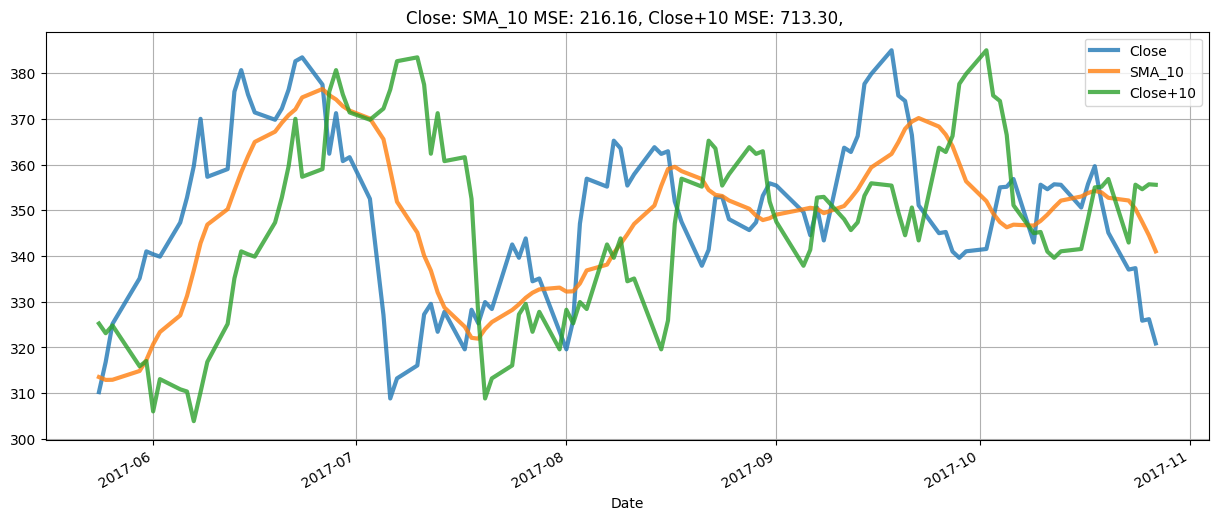

In [31]:
data['SMA_5']  = data['Close'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_20'] = data['Close'].rolling(20).mean()

result(data,  targets = ['Close'], sol_cols = ['SMA_10', 'Close+10'])

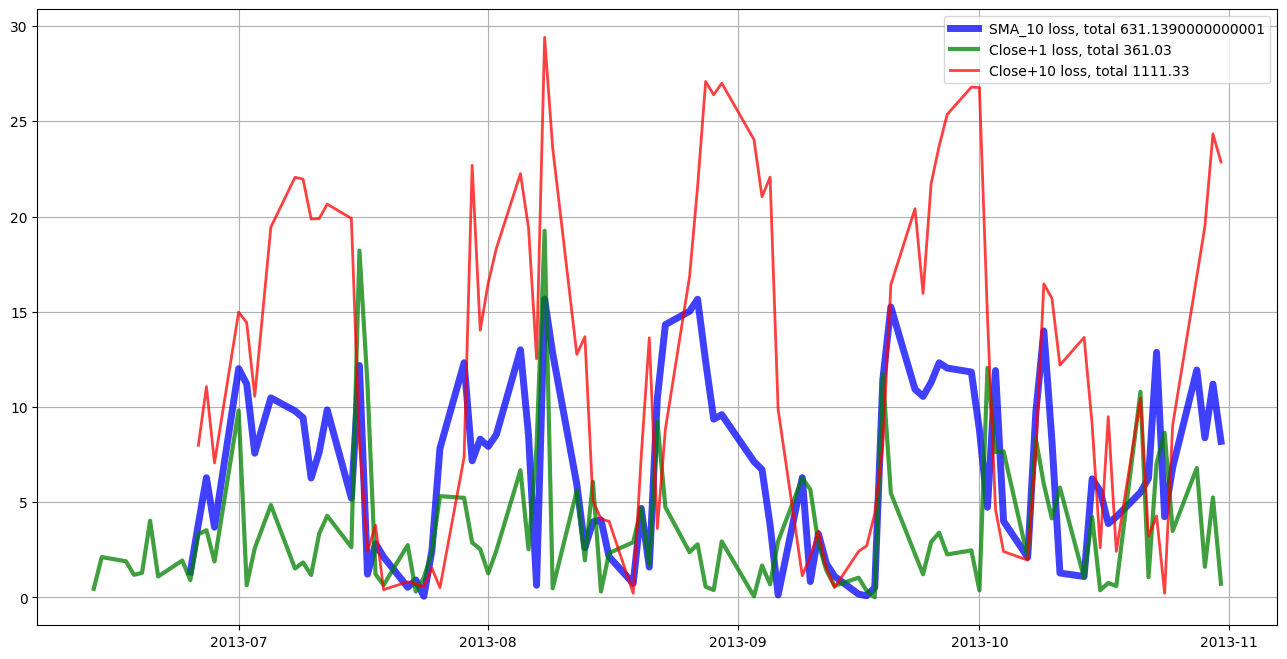

In [32]:
plt.figure(figsize=(16,8))

def draw_loss(target, c, lw):
    points = np.abs(data.head(100)['Close'] - data.head(100)[target])
    plt.plot(points, c=c, label=f'{target} loss, total {points.sum()}', lw=lw, alpha=.75)

draw_loss('SMA_10','b', 5)
draw_loss('Close+1','g', 3)
draw_loss('Close+10','r', 2)
plt.legend()
plt.grid()

### 3. Exponential average

$$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

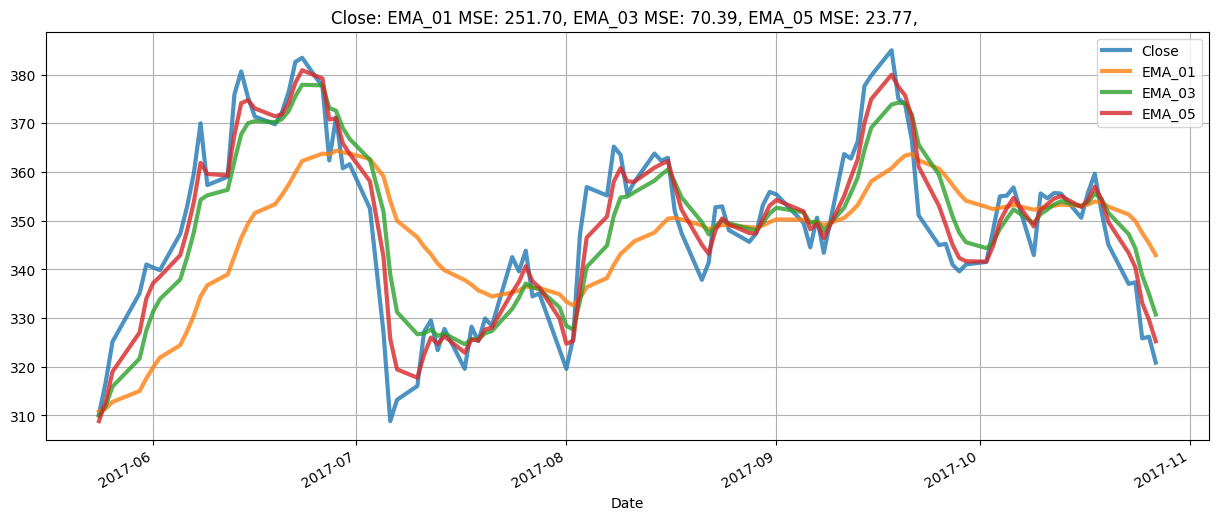

In [33]:
data['EMA_005']  = data['Close'].ewm(alpha=0.05).mean()
data['EMA_01']  = data['Close'].ewm(alpha=0.1).mean()
data['EMA_02']  = data['Close'].ewm(alpha=0.2).mean()
data['EMA_03']  = data['Close'].ewm(alpha=0.3).mean()
data['EMA_05']  = data['Close'].ewm(alpha=0.5).mean()


result(data, targets = ['Close'], sol_cols = ['EMA_01','EMA_03', 'EMA_05'])

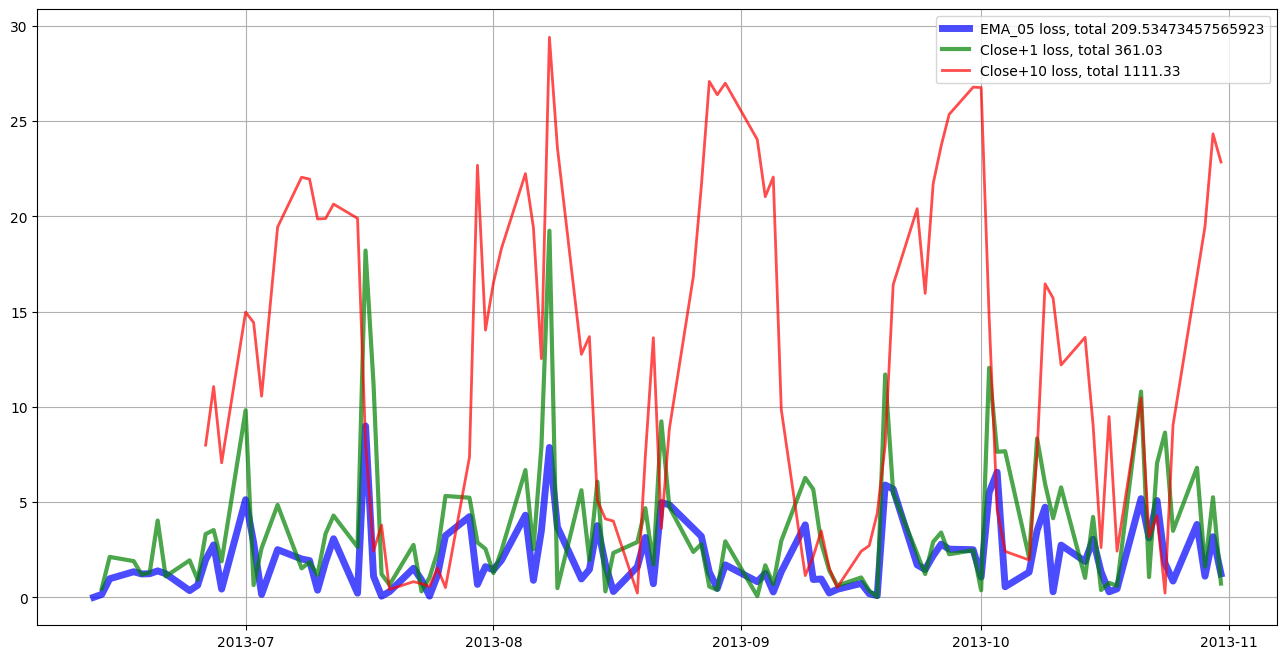

In [34]:
plt.figure(figsize=(16,8))

def draw_loss(target, c, lw):
    points = np.abs(data.head(100)['Close'] - data.head(100)[target])
    plt.plot(points, c=c, label=f'{target} loss, total {points.sum()}', lw=lw, alpha=.7)

draw_loss('EMA_05','b', 5)
draw_loss('Close+1','g', 3)
draw_loss('Close+10','r', 2)
plt.legend()
plt.grid()

## Метрики

In [35]:
from sklearn.metrics import max_error as ME, mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE

#### Max error

$$\text{Max Error}(y, \hat{y}) = max(| y_i - \hat{y}_i |)$$

#### Mean absolute error

$$\text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|.$$

#### Mean squared error

$$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$$

#### Mean absolute percentage error

$$\text{MAPE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \frac{{}\left| y_i - \hat{y}_i \right|}{max(\epsilon, \left| y_i \right|)}$$